<a href="https://colab.research.google.com/github/YolandaMDavis/cs109a-fall2020/blob/main/FinalProject_models_James.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from prettytable import PrettyTable

DATA_ROOT = '/content/drive/My Drive/Final-Project-for-CS109a/Milestone3/'
random_state = 109

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Data importing and preparing predictors and Response

In [3]:
new_york_crime_data_df = pd.read_csv(DATA_ROOT + 'nyc_crime_analysis_data_final.csv').drop(columns=["Unnamed: 0"])
boston_crime_data_df = pd.read_csv(DATA_ROOT + 'boston_crime_analysis_data_final.csv').drop(columns=["Unnamed: 0"])

In [4]:
boston_crime_data_df.columns

Index(['AREA', 'YEAR', 'MONTH', 'DAY_OF_WEEK', 'HOUR', 'LATITUDE', 'LONGITUDE',
       'GEOHASH', 'COVID_PERIOD', 'WHITE', 'BLACK', 'ASIAN', 'HISPANIC',
       'MEDIAN_INCOME', 'LOCAL_PROP_VALUES', 'STREETLIGHT_DISTANCE',
       'POLICE_STATION_DISTANCE', 'HOSPITAL_DISTANCE', 'COLLEGE_UNIV_DISTANCE',
       'ELECTION', 'PRCP', 'SNOW', 'NIGHT', 'OFFENSE_TYPE', 'VIOLENT_CRIME'],
      dtype='object')

Renaming STREETLIGHT_DISTANCE to STREETLIGHT_DENSITY, to reflect what it is actually measuring

In [5]:
# creating new interaction of night and streetlight, dropping streetlight_distance
# boston_crime_data_df['NIGHT_STREETLIGHT_DENSITY'] = boston_crime_data_df['STREETLIGHT_DISTANCE']*boston_crime_data_df['NIGHT']
# boston_crime_data_df.drop(columns=['STREETLIGHT_DISTANCE'], inplace=True)
# new_york_crime_data_df['NIGHT_STREETLIGHT_DENSITY'] = new_york_crime_data_df['STREETLIGHT_DISTANCE']*new_york_crime_data_df['NIGHT']
# new_york_crime_data_df.drop(columns=['STREETLIGHT_DISTANCE'], inplace=True)

boston_crime_data_df.rename(columns = {'STREETLIGHT_DISTANCE':'STREETLIGHT_DENSITY'}, inplace = True) 
new_york_crime_data_df.rename(columns = {'STREETLIGHT_DISTANCE':'STREETLIGHT_DENSITY'}, inplace = True) 

For Boston predictors, dropping outcomes, and geohash. For Generalized/Full, dropping also Lat/Long and Area. Using random_state to create same split for each team member

In [7]:
boston_X = boston_crime_data_df.drop(columns=['OFFENSE_TYPE', 'VIOLENT_CRIME', 'GEOHASH'])
boston_y = boston_crime_data_df['VIOLENT_CRIME']
boston_multi_y = boston_crime_data_df['OFFENSE_TYPE']

# Create Train/Test splits for Boston
boston_X_train, boston_X_test, boston_y_train, boston_y_test = train_test_split(boston_X, boston_y, train_size=.8, random_state = random_state)

# Train/Test splits for Multi-class
boston_X_train, boston_X_test, boston_multi_y_train, boston_multi_y_test = train_test_split(boston_X, boston_multi_y, train_size=.8, random_state = random_state)

# Combine Data Sets and split for Generalized Analysis
combined_crime_data_df = pd.concat([boston_crime_data_df, new_york_crime_data_df])
combined_crime_X = combined_crime_data_df.drop(columns=['OFFENSE_TYPE', 'VIOLENT_CRIME', 'GEOHASH', 'LATITUDE', 'LONGITUDE', 'AREA'])
combined_crime_y = combined_crime_data_df['VIOLENT_CRIME']
combined_crime_multi_y = combined_crime_data_df['OFFENSE_TYPE']

# Train/Test splits for full dataset
full_X_train, full_X_test, full_y_train, full_y_test = train_test_split(combined_crime_X, combined_crime_y, train_size=.8, random_state = random_state)
# Train/Test splits for full dataset, multi-class
full_X_train, full_X_test, full_multi_y_train, full_multi_y_test = train_test_split(combined_crime_X, combined_crime_multi_y, train_size=.8, random_state = random_state)

Take a look at the data, Make sure the columns look correct

In [8]:
boston_X_train.head()

,AREA,YEAR,MONTH,DAY_OF_WEEK,HOUR,LATITUDE,LONGITUDE,COVID_PERIOD,WHITE,BLACK,ASIAN,HISPANIC,MEDIAN_INCOME,LOCAL_PROP_VALUES,STREETLIGHT_DENSITY,POLICE_STATION_DISTANCE,HOSPITAL_DISTANCE,COLLEGE_UNIV_DISTANCE,ELECTION,PRCP,SNOW,NIGHT
2742,E13,2019,10,Thursday,2,42.352341,-71.062969,0,0.550542,0.111894,0.061581,0.237167,84445.9000,9.305048e+06,32.0,652.050031,251.777302,109.854794,0.0600,0.02,0.0,1.0
26647,A1,2020,1,Monday,16,42.366435,-71.061354,0,0.727176,0.030437,0.140236,0.080069,89833.4675,7.404941e+07,12.0,520.414789,197.460227,543.641269,0.2775,0.01,0.0,0.0
198235,A1,2016,7,Monday,20,42.361110,-71.067414,0,0.727176,0.030437,0.140236,0.080069,89833.4675,3.901778e+07,49.0,590.590051,233.028485,278.147512,0.2775,0.01,0.0,1.0
51448,B3,2020,5,Friday,23,42.277963,-71.092463,1,0.067967,0.730087,0.017705,0.153209,48196.9000,4.666762e+06,18.0,748.546146,2203.859460,2248.707217,0.0400,0.79,0.0,1.0
68679,B3,2020,7,Tuesday,16,42.280727,-71.077136,1,0.067967,0.730087,0.017705,0.153209,48196.9000,7.851202e+06,0.0,1276.128447,1010.720978,1053.834615,0.0400,0.62,0.0,0.0


In [9]:
full_X_train.head()

,YEAR,MONTH,DAY_OF_WEEK,HOUR,COVID_PERIOD,WHITE,BLACK,ASIAN,HISPANIC,MEDIAN_INCOME,LOCAL_PROP_VALUES,STREETLIGHT_DENSITY,POLICE_STATION_DISTANCE,HOSPITAL_DISTANCE,COLLEGE_UNIV_DISTANCE,ELECTION,PRCP,SNOW,NIGHT
242278,2020,2,Thursday,19,0,0.090989,0.290291,0.038122,0.561581,38740.127767,4.455077e+05,0.0,703.963608,355.539466,2071.643885,0.11,0.40,0.0,0.0
229277,2016,11,Thursday,19,0,0.215249,0.453834,0.094452,0.180933,49662.360000,1.050727e+06,6.0,1509.431329,2638.058680,1828.886949,0.20,0.00,0.0,0.0
240914,2017,1,Friday,13,0,0.550542,0.111894,0.061581,0.237167,84445.900000,2.479460e+06,30.0,838.491817,568.757936,1583.991917,0.06,0.06,1.1,0.0
377031,2018,6,Friday,20,0,0.731972,0.058357,0.071636,0.118406,103243.160000,7.567873e+05,60.0,764.090021,458.477056,716.029361,0.28,0.00,0.0,1.0
80815,2020,8,Sunday,21,1,0.325667,0.025571,0.038067,0.574151,52935.360000,1.173795e+06,8.0,915.779139,1566.465488,1731.148782,0.31,0.00,0.0,1.0


## One hot encoding for categorical. 
### Different set for Boston and Generalized (full), since Area and Lat/Long were dropped from the larger dataset

In [10]:
# prep data -- one hot encoding for categoricals, different for boston and full
categoricals_boston = ['AREA', 'DAY_OF_WEEK']
categoricals_full = ['DAY_OF_WEEK']

boston_X_train, boston_X_test = pd.get_dummies(boston_X_train, columns=categoricals_boston), pd.get_dummies(boston_X_test, columns=categoricals_boston)
full_X_train, full_X_test = pd.get_dummies(full_X_train, columns=categoricals_full), pd.get_dummies(full_X_test, columns=categoricals_full)


## Creating scaled data sets (for kNN and Neural Network)

In [ ]:

boston_scaler = MinMaxScaler().fit(boston_X_train)
boston_X_train_scaled = boston_scaler.transform(boston_X_train)
boston_X_test_scaled = boston_scaler.transform(boston_X_test)

full_scaler = MinMaxScaler().fit(full_X_train)
full_X_train_scaled = full_scaler.transform(full_X_train)
full_X_test_scaled = full_scaler.transform(full_X_test)

## Factorizing multiclass Y for models

In [55]:
boston_multi_y_train, categories = pd.factorize(boston_multi_y_train, sort=True)
boston_multi_y_test, categories = pd.factorize(boston_multi_y_test, sort=True)

full_multi_y_train, categories = pd.factorize(full_multi_y_train, sort=True)
full_multi_y_test, categories = pd.factorize(full_multi_y_test, sort=True)

## Smaller datasets for use in developing NN models

In [ ]:
# reduce the number of rows by 10 for NN to work a bit faster, for tuning...
# index = np.random.choice(boston_X_train.shape[0], int(boston_X_train.shape[0]/10), replace=False)
# boston_X_train_sample = boston_X_train[index,:]
# boston_y_train_sample = boston_y_train.iloc[index]

In [ ]:
# from sklearn.utils import class_weight

# class_weights = class_weight.compute_class_weight('balanced',
#                                                  np.unique(boston_y_train),
#                                                  boston_y_train)
# class_weights = dict(enumerate(class_weights))      

##  Neural Network Definition and Summary - Violent Crime

In [ ]:
nn_boston_VC = tf.keras.models.Sequential(name='Boston_Violent')

regularizer = tf.keras.regularizers.l2(0.01)

nn_boston_VC.add(tf.keras.layers.Dense(30, activation="tanh", input_shape=(boston_X_train.shape[1],), name="hidden1"))
nn_boston_VC.add(tf.keras.layers.Dense(1000, activation="relu", name="hidden2"))
nn_boston_VC.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [ ]:
loss_fn = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(0.001)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

nn_boston_VC.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [ ]:
nn_boston_VC.summary()

In [ ]:
%%time
# Naive model classification = 0.918

history = nn_boston_VC.fit(boston_X_train_scaled, boston_y_train, validation_split=0.2, epochs=500, batch_size=256, callbacks=[callback], verbose=2)

## Neural Network Definition and Summary - Offense Type

In [ ]:
# define nn
nn_boston = tf.keras.models.Sequential(name='Boston')

regularizer = tf.keras.regularizers.l2(0.01)

nn_boston.add(tf.keras.layers.Dense(30, activation="tanh", input_shape=(boston_X_train.shape[1],), name="hidden1"))
nn_boston.add(tf.keras.layers.Dense(1000, activation="relu", name="hidden2"))
nn_boston.add(tf.keras.layers.Dropout(0.3))
nn_boston.add(tf.keras.layers.Dense(1000, activation="relu", name="hidden3"))
nn_boston.add(tf.keras.layers.Dropout(0.4))
nn_boston.add(tf.keras.layers.Dense(19, activation="softmax"))

In [ ]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(0.0001)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

nn_boston.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [ ]:
nn_boston.summary()

Model: "Boston"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 30)                1200      
_________________________________________________________________
hidden2 (Dense)              (None, 1000)              31000     
_________________________________________________________________
dropout_13 (Dropout)         (None, 1000)              0         
_________________________________________________________________
hidden3 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dropout_14 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 19)                19019     
Total params: 1,052,219
Trainable params: 1,052,219
Non-trainable params: 0
__________________________________________________

## Neural Network for Offense Type in Boston

In [ ]:
%%time
# Naive model classification = 0.45/0.451

history = nn_boston.fit(boston_X_train_scaled, boston_multi_y_train, validation_split=0.2, epochs=500, batch_size=256, callbacks=[callback], verbose=2)

Epoch 1/500
1230/1230 - 3s - loss: 1.8376 - accuracy: 0.4486 - val_loss: 1.7928 - val_accuracy: 0.4515
Epoch 2/500
1230/1230 - 3s - loss: 1.8014 - accuracy: 0.4500 - val_loss: 1.7874 - val_accuracy: 0.4523
Epoch 3/500
1230/1230 - 3s - loss: 1.7941 - accuracy: 0.4503 - val_loss: 1.7846 - val_accuracy: 0.4515
Epoch 4/500
1230/1230 - 3s - loss: 1.7895 - accuracy: 0.4508 - val_loss: 1.7801 - val_accuracy: 0.4523
Epoch 5/500
1230/1230 - 3s - loss: 1.7859 - accuracy: 0.4510 - val_loss: 1.7786 - val_accuracy: 0.4525
Epoch 6/500
1230/1230 - 3s - loss: 1.7821 - accuracy: 0.4513 - val_loss: 1.7747 - val_accuracy: 0.4524
Epoch 7/500
1230/1230 - 3s - loss: 1.7799 - accuracy: 0.4511 - val_loss: 1.7735 - val_accuracy: 0.4528
Epoch 8/500
1230/1230 - 3s - loss: 1.7774 - accuracy: 0.4518 - val_loss: 1.7718 - val_accuracy: 0.4532
Epoch 9/500
1230/1230 - 3s - loss: 1.7749 - accuracy: 0.4519 - val_loss: 1.7692 - val_accuracy: 0.4529
Epoch 10/500
1230/1230 - 3s - loss: 1.7727 - accuracy: 0.4523 - val_loss:

Text(0.5, 0.98, 'NN Training')

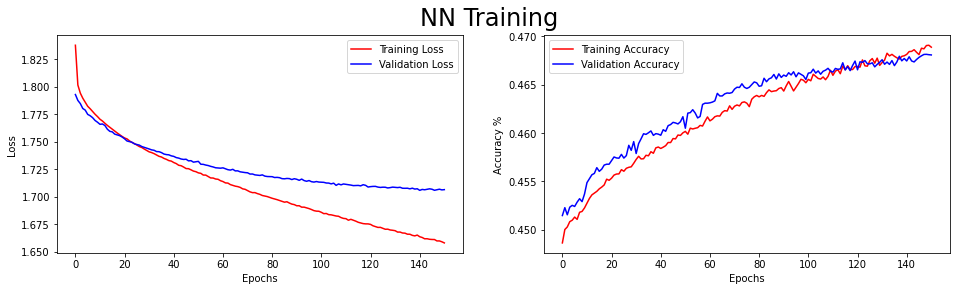

In [ ]:
fig, ax = plt.subplots(1,2,figsize = (16,4))
ax[0].plot(history.history['loss'],'r',label = 'Training Loss')
ax[0].plot(history.history['val_loss'],'b',label = 'Validation Loss')
ax[1].plot(history.history['accuracy'],'r',label = 'Training Accuracy')
ax[1].plot(history.history['val_accuracy'],'b',label = 'Validation Accuracy')
ax[0].legend()
ax[1].legend()
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs');
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy %');
fig.suptitle('NN Training', fontsize = 24)

In [ ]:
predict_proba_train = nn_boston.predict(boston_X_train_scaled)
y_pred_train_nn_boston = np.apply_along_axis(np.argmax, 1, predict_proba_train)

predict_proba_test = nn_boston.predict(boston_X_test_scaled)
y_pred_test_nn_boston = np.apply_along_axis(np.argmax, 1, predict_proba_test)

nn_train_score_boston = accuracy_score(boston_multi_y_train, y_pred_train_nn_boston)
nn_test_score_boston = accuracy_score(boston_multi_y_test, y_pred_test_nn_boston)

print(f"""Neural Network: 
train accuracy is {nn_train_score_boston:.4f} and
test accuracy is {nn_test_score_boston:.4f}""")

Neural Network: 
train accuracy is 0.4732 and
test accuracy is 0.4676


## Binarizing Y to get AUC score for NN

In [ ]:

# binarizing to get AUC score
labels = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
y_test_bin = label_binarize(boston_multi_y_test, classes=labels)
y_pred_test_bin = label_binarize(y_pred_test_nn_boston, classes=labels)

In [ ]:
roc_auc_score(y_test_bin, y_pred_test_bin,average='macro',multi_class='ovo')

0.5171396020787601

# Random Forest Classifier

In [11]:
%%time
#BOSTON Random Forest
# Naive model = 0.918


n_trees = 210
tree_depth = 20

rf_boston = RandomForestClassifier(max_depth=tree_depth, n_estimators=n_trees, max_features='sqrt', random_state=random_state)
rf_boston.fit(boston_X_train, boston_y_train)

y_pred_train_rf_boston = rf_boston.predict(boston_X_train)
y_pred_test_rf_boston = rf_boston.predict(boston_X_test)

rf_train_score_boston = accuracy_score(boston_y_train, y_pred_train_rf_boston)
rf_test_score_boston = accuracy_score(boston_y_test, y_pred_test_rf_boston)

print(f"""Random Forest with {tree_depth} max_depth and {n_trees} trees, 
train accuracy is {rf_train_score_boston:.4f} and
test accuracy is {rf_test_score_boston:.4f}""")

Random Forest with 20 max_depth and 210 trees, 
train accuracy is 0.9335 and
test accuracy is 0.9274
CPU times: user 2min 51s, sys: 320 ms, total: 2min 52s
Wall time: 2min 52s


## Finding F1 and AUC, better determination of RF accuracy, and to compare with balancing class weights and using SMOTE to upsample "violence" category

In [12]:
# f1 and AUC scores for RF
f1_rf_boston = f1_score(boston_y_test, y_pred_test_rf_boston)
auc_rf_boston = roc_auc_score(boston_y_test, y_pred_test_rf_boston)

print(f"""Random Forest (Boston/Violence) 
F1: {f1_rf_boston:.4f}
AUC: {auc_rf_boston}
""")

Random Forest (Boston/Violence) 
F1: 0.2175
AUC: 0.561236159629013



## RF (Boston/Violence) with balanced class weights

In [13]:
# use balanced weights for Boston RF
n_trees = 210
tree_depth = 20

rf_boston_bal = RandomForestClassifier(max_depth=tree_depth, n_estimators=n_trees, max_features='sqrt', class_weight='balanced_subsample', random_state=random_state)
rf_boston_bal.fit(boston_X_train, boston_y_train)

y_pred_train_rf_boston_bal = rf_boston_bal.predict(boston_X_train)
y_pred_test_rf_boston_bal = rf_boston_bal.predict(boston_X_test)

rf_train_score_boston_bal = accuracy_score(boston_y_train, y_pred_train_rf_boston_bal)
rf_test_score_boston_bal = accuracy_score(boston_y_test, y_pred_test_rf_boston_bal)

print(f"""Random Forest (balanced class weights) with {tree_depth} max_depth and {n_trees} trees, 
train accuracy is {rf_train_score_boston_bal:.4f} and
test accuracy is {rf_test_score_boston_bal:.4f}""")

Random Forest (balanced class weights) with 20 max_depth and 210 trees, 
train accuracy is 0.9503 and
test accuracy is 0.8923


## Trying Hyperparameter tuning of n_estimators and max_depth

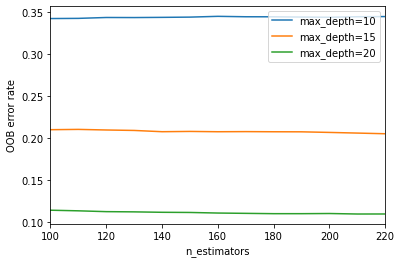

CPU times: user 1h 22min 13s, sys: 12.8 s, total: 1h 22min 26s
Wall time: 1h 22min 29s


In [13]:
%%time
from collections import OrderedDict
ensemble_clfs = [
    (10,
        RandomForestClassifier( 
                               oob_score=True,
                               max_depth = 10,
                               class_weight='balanced_subsample',
                               random_state=random_state)),
    (15,
        RandomForestClassifier( 
                               oob_score=True,
                               max_depth = 15,
                               class_weight='balanced_subsample',
                               random_state=random_state)),
    (20,
        RandomForestClassifier( 
                               oob_score=True,
                               max_depth = 20,
                               class_weight='balanced_subsample',
                               random_state=random_state)),
                 
]

# Map a label (the value of `min_samples_leaf`) to a list of (model, oob error) tuples.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

min_estimators = 100
max_estimators = 220

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 10):
        clf.set_params(n_estimators=i) 
        clf.fit(boston_X_train, boston_y_train)

        # Record the OOB error for each model. Error is 1 - oob_score
        # oob_score: score of the training dataset obtained using an 
        # out-of-bag estimate.
        # OOB error rate is % of num_missclassified/total observations
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=f'max_depth={label}')

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

In [15]:
# f1 and AUC scores for RF
f1_rf_boston_bal = f1_score(boston_y_test, y_pred_test_rf_boston_bal)
auc_rf_boston_bal = roc_auc_score(boston_y_test, y_pred_test_rf_boston_bal)

print(f"""Random Forest (Boston/Violence) with balanced class weights. 
F1: {f1_rf_boston_bal:.4f}
AUC: {auc_rf_boston_bal}
""")

Random Forest (Boston/Violence) with balanced class weights. 
F1: 0.2933
AUC: 0.6104605601381533



## RF with balanced class weights, but also supplemented with SMOTE, to upsample more violent crimes

In [42]:
# use smote to expland small class of violent crime
sm = SMOTE(random_state=random_state)

boston_X_train_res, boston_y_train_res = sm.fit_sample(boston_X_train, boston_y_train.ravel())

print(f'Number of points in balanced dataset is {boston_X_train_res.shape[0]}')

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Number of points in balanced dataset is 722556


In [43]:
%%time
n_trees = 210
tree_depth = 20

rf_boston_smote = RandomForestClassifier(max_depth=tree_depth, n_estimators=n_trees, max_features='sqrt', class_weight='balanced_subsample', random_state=random_state)
rf_boston_smote.fit(boston_X_train_res, boston_y_train_res)

y_pred_train_rf_boston_smote = rf_boston_smote.predict(boston_X_train_res)
y_pred_test_rf_boston_smote = rf_boston_smote.predict(boston_X_test)

rf_train_score_boston_smote = accuracy_score(boston_y_train_res, y_pred_train_rf_boston_smote)
rf_test_score_boston_smote = accuracy_score(boston_y_test, y_pred_test_rf_boston_smote)

print(f"""Random Forest (balanced class weights) with {tree_depth} max_depth and {n_trees} trees, 
train accuracy is {rf_train_score_boston_smote:.4f} and
test accuracy is {rf_test_score_boston_smote:.4f}""")

Random Forest (balanced class weights) with 20 max_depth and 210 trees, 
train accuracy is 0.9480 and
test accuracy is 0.9265
CPU times: user 8min 27s, sys: 665 ms, total: 8min 28s
Wall time: 8min 28s


In [44]:
# f1 and AUC scores for RF with SMOTE
f1_rf_boston_smote = f1_score(boston_y_test, y_pred_test_rf_boston_smote)
auc_rf_boston_smote = roc_auc_score(boston_y_test, y_pred_test_rf_boston_smote)

print(f"""Random Forest (Boston/Violence) with balanced class weights. 
F1: {f1_rf_boston_smote:.4f}
AUC: {auc_rf_boston_smote}
""")

Random Forest (Boston/Violence) with balanced class weights. 
F1: 0.2482
AUC: 0.5721157909473845



## Let's compare the different RF models F1 and AUC for Boston/Violence

In [50]:
print('Random Forest - Boston. Predicting Violent Crime')
pt = PrettyTable()
pt.field_names = ["Strategy","F1 Score","AUC score", "Train Acc", "Test Acc"]
pt.add_row(["RF - no correction",f1_rf_boston,auc_rf_boston, rf_train_score_boston, rf_test_score_boston])
pt.add_row(["RF - class weighting",f1_rf_boston_bal,auc_rf_boston_bal, rf_train_score_boston_bal, rf_test_score_boston_bal])
pt.add_row(["RF - SMOTE upsampling",f1_rf_boston_smote,auc_rf_boston_smote, rf_train_score_boston_smote, rf_test_score_boston_smote])
print(pt)

Random Forest - Boston. Predicting Violent Crime
+-----------------------+---------------------+--------------------+--------------------+--------------------+
|        Strategy       |       F1 Score      |     AUC score      |     Train Acc      |      Test Acc      |
+-----------------------+---------------------+--------------------+--------------------+--------------------+
|   RF - no correction  | 0.21752464403066812 | 0.561236159629013  | 0.933469914797568  | 0.9273651568298511 |
|  RF - class weighting | 0.29326570112794503 | 0.6104605601381533 | 0.950261301014702  | 0.8923389761577958 |
| RF - SMOTE upsampling | 0.24817973788225506 | 0.5721157909473845 | 0.9480358615802789 | 0.9265111077220274 |
+-----------------------+---------------------+--------------------+--------------------+--------------------+


Looks like class weighting improves AUC the most. SMOTE did increase the dataset by quite a lot, but doesn't seem to have imporoved the model much.

In [25]:
# helper code to plot feature importances for tree-based models
def plot_importances(model, X, num):
    model_importances = model.feature_importances_
    model_importances = pd.Series(model_importances).fillna(0)
    order = np.flip(np.argsort(model_importances))[0:num]
    plt.barh(range(num),model_importances[order],tick_label=X.columns[order]);
    plt.title(f"Relative Variable Importances for {type(model).__name__}")

RF with n_trees = 200, max_depth = 10. Test accuracy = 0.9227
n_trees = 210, max_depth = 20. Test accuracy = 0.9273

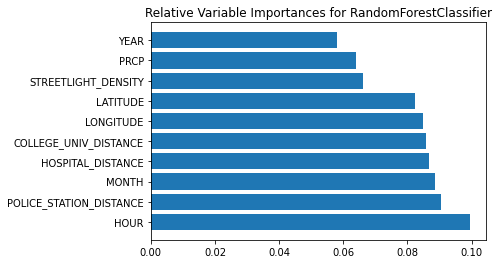

In [52]:
plot_importances(rf_boston, boston_X_train, 10)

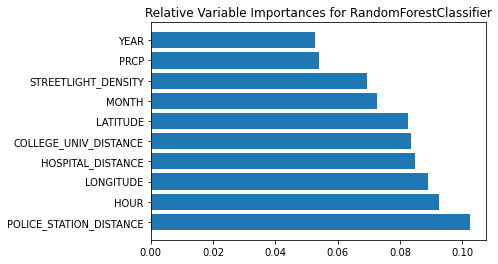

In [53]:
plot_importances(rf_boston_bal, boston_X_train, 10)

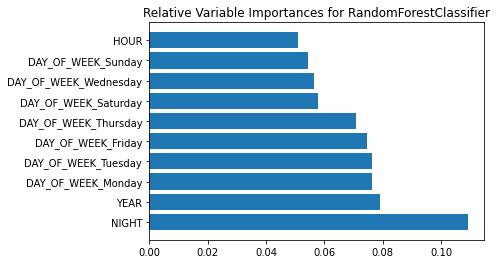

In [56]:
plot_importances(rf_boston_smote, boston_X_train, 10)

In [ ]:
# def plot_permute_importance(importances,X,y):
#   plt.figure(figsize=(10,10))

#   tree_importance_sorted_idx = np.argsort(importances.importances_mean)
#   tree_indices = np.arange(0, len(importances.importances_mean)) +0.5

#   plt.barh(tree_indices, importances.importances_mean[tree_importance_sorted_idx], height=0.7, color='#EFAEA4')
#   plt.yticks(tree_indices, labels=X.columns[tree_importance_sorted_idx], fontsize=12)
#   plt.ylim((0, len(importances.importances_mean)))
#   plt.xlabel("Permutation Feature Importance", fontsize=16)
#   maxlim = max(importances.importances_mean)
#   plt.xlim(0,maxlim+0.015)
#   plt.title("Permutation Importance", fontsize=18)
#   plt.show()

In [ ]:
# from sklearn.inspection import permutation_importance

# rf_importances = permutation_importance(rf_boston, boston_X_train, boston_y_train, random_state=random_state)

# plot_permute_importance(rf_importances, boston_X_train, boston_y_train)

## Random Forest on Generalized (B&NYC) Dataset

In [12]:
%%time
#Full Random Forest
n_trees = 210
tree_depth = 20

rf_full = RandomForestClassifier(max_depth=tree_depth, n_estimators=n_trees, max_features='sqrt', random_state=51)
rf_full.fit(full_X_train, full_y_train)

y_pred_train_rf_full = rf_full.predict(full_X_train)
y_pred_test_rf_full = rf_full.predict(full_X_test)

rf_train_score_full = accuracy_score(full_y_train, y_pred_train_rf_full)
rf_test_score_full = accuracy_score(full_y_test, y_pred_test_rf_full)

print(f"""Random Forest with {tree_depth} max_depth and {n_trees} trees, 
train accuracy is {rf_train_score_full:.3f} and
test accuracy is {rf_test_score_full:.3f}""")

Random Forest with 20 max_depth and 210 trees, 
train accuracy is 0.901 and
test accuracy is 0.894
CPU times: user 6min 28s, sys: 692 ms, total: 6min 29s
Wall time: 6min 30s


## Generalized: AUC for comparison

In [23]:
# f1 and AUC scores for RF
auc_rf_full_train = roc_auc_score(full_y_train, y_pred_train_rf_full)
auc_rf_full_test = roc_auc_score(full_y_test, y_pred_test_rf_full)

print(f"""Random Forest AUCs (Generalized/Violence) 
Train: {auc_rf_full_train:.4f}
Test: {auc_rf_full_test:.4f}
""")

Random Forest AUCs (Generalized/Violence) 
Train: 0.5791
Test: 0.5551



## Random Forest (Generalized/Violence) with balanced weights

In [16]:
n_trees = 210
tree_depth = 20

rf_full_bal = RandomForestClassifier(max_depth=tree_depth, n_estimators=n_trees, max_features='sqrt', class_weight="balanced_subsample", random_state=51)
rf_full_bal.fit(full_X_train, full_y_train)

y_pred_train_rf_full_bal = rf_full_bal.predict(full_X_train)
y_pred_test_rf_full_bal = rf_full_bal.predict(full_X_test)

rf_train_score_full_bal = accuracy_score(full_y_train, y_pred_train_rf_full_bal)
rf_test_score_full_bal = accuracy_score(full_y_test, y_pred_test_rf_full_bal)

print(f"""Random Forest (Generalized/Violence) Balanced Class Weights with {tree_depth} max_depth and {n_trees} trees, 
train accuracy is {rf_train_score_full_bal:.3f} and
test accuracy is {rf_test_score_full_bal:.3f}""")

Random Forest with 20 max_depth and 210 trees, 
train accuracy is 0.856 and
test accuracy is 0.789


## Generalized/Violence (Balanced Weights): AUC

In [22]:
auc_rf_full_bal_train = roc_auc_score(full_y_train, y_pred_train_rf_full_bal)
auc_rf_full_bal_test = roc_auc_score(full_y_test, y_pred_test_rf_full_bal)

print(f"""Random Forest with balanced class weights AUCs(Generalized/Violence) 
Train: {auc_rf_full_bal_train:.4f}
Test: {auc_rf_full_bal_test:.4f}
""")

Random Forest with balanced class weights AUCs(Generalized/Violence) 
Train: 0.8354
Test: 0.6466



## RF (Generalized/Violence) with SMOTE for upsampling

In [18]:
sm2 = SMOTE(random_state=random_state)

full_X_train_res, full_y_train_res = sm2.fit_sample(full_X_train, full_y_train.ravel())

print(f'Length of balanced dataset: {full_X_train_res.shape[0]}')

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Length of balanced dataset: 1126372


## Random Forest (Generalized/Violence) on SMOTE enhanced data

In [31]:
%%time
# n_trees = 210
# tree_depth = 20

# rf_full_smote = RandomForestClassifier(max_depth=tree_depth, n_estimators=n_trees, max_features='sqrt', class_weight="balanced_subsample", random_state=51)
# rf_full_smote.fit(full_X_train_res, full_y_train_res)

y_pred_train_rf_full_smote = rf_full_smote.predict(full_X_train)
y_pred_test_rf_full_smote = rf_full_smote.predict(full_X_test)

rf_train_score_full_smote = accuracy_score(full_y_train, y_pred_train_rf_full_smote)
rf_test_score_full_smote = accuracy_score(full_y_test, y_pred_test_rf_full_smote)

print(f"""Random Forest with SMOTE {tree_depth} max_depth and {n_trees} trees, 
train accuracy is {rf_train_score_full_smote:.3f} and
test accuracy is {rf_test_score_full_smote:.3f}""")

Random Forest with SMOTE 20 max_depth and 210 trees, 
train accuracy is 0.899 and
test accuracy is 0.893
CPU times: user 49.2 s, sys: 59 ms, total: 49.3 s
Wall time: 49.3 s


In [32]:
auc_rf_full_smote_train = roc_auc_score(full_y_train, y_pred_train_rf_full_smote)
auc_rf_full_smote_test = roc_auc_score(full_y_test, y_pred_test_rf_full_smote)

print(f"""Random Forest with SMOTE AUCs(Generalized/Violence) 
Train: {auc_rf_full_smote_train:.4f}
Test: {auc_rf_full_smote_test:.4f}
""")

Random Forest with SMOTE AUCs(Generalized/Violence) 
Train: 0.5736
Test: 0.5549



## Generalized/Violence - AUC and ACC table

In [33]:
print('Random Forest - Generalized. Predicting Violent Crime')
pt = PrettyTable()
pt.field_names = ["Strategy","AUC Train", "AUC Test", "Train Acc", "Test Acc"]
pt.add_row(["RF - no correction",auc_rf_full_train,auc_rf_full_test, rf_train_score_full, rf_test_score_full])
pt.add_row(["RF - class weighting",auc_rf_full_bal_train,auc_rf_full_bal_test, rf_train_score_full_bal, rf_test_score_full_bal])
pt.add_row(["RF - SMOTE upsampling",auc_rf_full_smote_train,auc_rf_full_smote_test, rf_train_score_full_smote, rf_test_score_full_smote])
print(pt)

Random Forest - Generalized. Predicting Violent Crime
+-----------------------+--------------------+--------------------+--------------------+--------------------+
|        Strategy       |     AUC Train      |      AUC Test      |     Train Acc      |      Test Acc      |
+-----------------------+--------------------+--------------------+--------------------+--------------------+
|   RF - no correction  | 0.5790549984447901 | 0.5550764477714273 | 0.900680870925856  | 0.8941808886549883 |
|  RF - class weighting | 0.8354168904109591 | 0.6466224348653091 | 0.8564093808883118 | 0.7890572137433276 |
| RF - SMOTE upsampling | 0.5736130934030048 | 0.5548749398870881 | 0.8988279371662801 | 0.8933789439390522 |
+-----------------------+--------------------+--------------------+--------------------+--------------------+


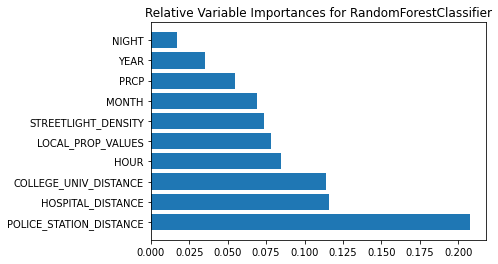

In [34]:
plot_importances(rf_full, full_X_train, 10)

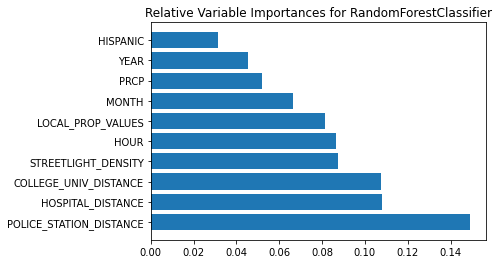

In [35]:
plot_importances(rf_full_bal, full_X_train, 10)

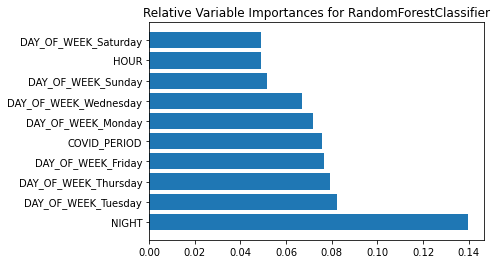

In [36]:
plot_importances(rf_full_smote, full_X_train, 10)

## Random Forest (Boston/Offense Type)

In [ ]:
%%time
n_trees = 300
tree_depth = 20

rf_boston = RandomForestClassifier(max_depth=tree_depth, n_estimators=n_trees, max_features='sqrt', random_state=51)
rf_boston.fit(boston_X_train, boston_multi_y_train)

y_pred_rf_boston_multi_train = rf_boston.predict(boston_X_train)
y_pred_rf_boston_multi_test = rf_boston.predict(boston_X_test)

rf_boston_multi_train = accuracy_score(boston_multi_y_train, y_pred_rf_boston_multi_train)
rf_boston_multi_test = accuracy_score(boston_multi_y_test, y_pred_rf_boston_multi_test)

print(f"""Random Forest with {tree_depth} max_depth and {n_trees} trees, 
train accuracy is {rf_boston_multi_train:.4f} and
test accuracy is {rf_boston_multi_test:.4f}""")

Random Forest with 20 max_depth and 300 trees, 
train accuracy is 0.6447 and
test accuracy is 0.4902


This train accuracy is quite good, but the test accuracy isn't so good. These seem possibly to be overfitting. With just 10 depth, we're not getting very good numbers. So we could set a min_samples_leaf to "prune back" the trees.

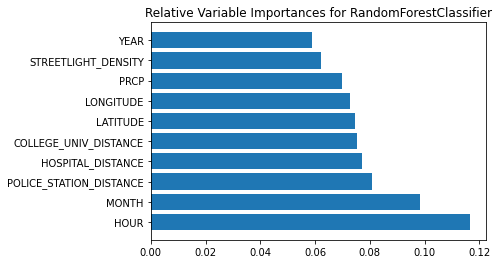

In [ ]:
plot_importances(rf_boston, boston_X_train, 10)

# Boston multifactor with pruning

In [ ]:
%%time
n_trees = 300
tree_depth = 20
min_samples = 50

rf_multi_pruned = RandomForestClassifier(max_depth=tree_depth, n_estimators=n_trees, max_features='sqrt', random_state=51, min_samples_leaf=min_samples)
rf_multi_pruned.fit(boston_X_train, boston_multi_y_train)

y_pred_rf_multi_pruned_train = rf_multi_pruned.predict(boston_X_train)
y_pred_rf_multi_pruned_test = rf_multi_pruned.predict(boston_X_test)

rf_multi_pruned_train = accuracy_score(boston_multi_y_train, y_pred_rf_multi_pruned_train)
rf_multi_pruned_test = accuracy_score(boston_multi_y_test, y_pred_rf_multi_pruned_test)

print(f"""Random Forest with {tree_depth} max_depth and {n_trees} trees, 
train accuracy is {rf_multi_pruned_train:.4f} and
test accuracy is {rf_multi_pruned_test:.4f}""")

Random Forest with 20 max_depth and 300 trees, 
train accuracy is 0.4818 and
test accuracy is 0.4777


This model doesn't really overfit, but we're not getting as good test accuracy as the deep model without min_samples_leaf set. Maybe a slightly lower setting for min_samples_leaf would work. (We could do all of this via cv and grid search, but each tree takes so long to run that this seems a better course).

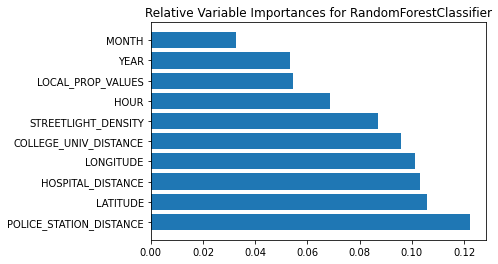

In [ ]:
plot_importances(rf_multi_pruned, boston_X_train, 10)

In [ ]:
# Boston multifactor with pruning
n_trees = 300
tree_depth = 20
min_samples = 25

rf_multi_pruned2 = RandomForestClassifier(max_depth=tree_depth, n_estimators=n_trees, max_features='sqrt', random_state=51, min_samples_leaf=min_samples)
rf_multi_pruned2.fit(boston_X_train, boston_multi_y_train)

y_pred_rf_multi_pruned_train2 = rf_multi_pruned2.predict(boston_X_train)
y_pred_rf_multi_pruned_test2 = rf_multi_pruned2.predict(boston_X_test)

rf_multi_pruned_train2 = accuracy_score(boston_multi_y_train, y_pred_rf_multi_pruned_train2)
rf_multi_pruned_test2 = accuracy_score(boston_multi_y_test, y_pred_rf_multi_pruned_test2)

print(f"""Random Forest with {tree_depth} max_depth and {n_trees} trees, 
train accuracy is {rf_multi_pruned_train2:.4f} and
test accuracy is {rf_multi_pruned_test2:.4f}""")

Random Forest with 20 max_depth and 300 trees, 
train accuracy is 0.4895 and
test accuracy is 0.4817


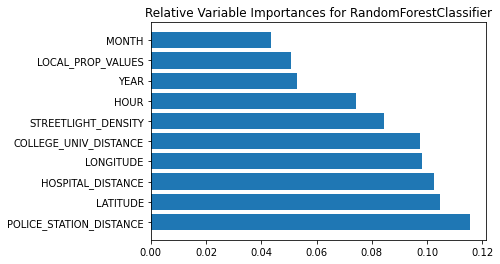

In [ ]:
plot_importances(rf_multi_pruned2, boston_X_train, 10)

# RF Boston/Offense type (final) with pruning




In [37]:
%%time
n_trees = 300
tree_depth = 20
min_samples = 10

rf_multi_pruned3 = RandomForestClassifier(max_depth=tree_depth, n_estimators=n_trees, max_features='sqrt', random_state=51, min_samples_leaf=min_samples)
rf_multi_pruned3.fit(boston_X_train, boston_multi_y_train)

y_pred_rf_multi_pruned_train3 = rf_multi_pruned3.predict(boston_X_train)
y_pred_rf_multi_pruned_test3 = rf_multi_pruned3.predict(boston_X_test)

rf_multi_pruned_train3 = accuracy_score(boston_multi_y_train, y_pred_rf_multi_pruned_train3)
rf_multi_pruned_test3 = accuracy_score(boston_multi_y_test, y_pred_rf_multi_pruned_test3)

print(f"""Random Forest with {tree_depth} max_depth and {n_trees} trees, 
train accuracy is {rf_multi_pruned_train3:.4f} and
test accuracy is {rf_multi_pruned_test3:.4f}""")

Random Forest with 20 max_depth and 300 trees, 
train accuracy is 0.5054 and
test accuracy is 0.4858
CPU times: user 5min 17s, sys: 1.59 s, total: 5min 18s
Wall time: 5min 19s


### Test/Train AUC for comparison

In [38]:
# binarizing multi_y train/test for to get AUC scores
labels = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
boston_multi_y_train_bin = label_binarize(boston_multi_y_train, classes=labels)
boston_multi_y_test_bin = label_binarize(boston_multi_y_test, classes=labels)


In [41]:
y_pred_rf_multi_pruned_train3_bin = label_binarize(y_pred_rf_multi_pruned_train3, classes=labels)
y_pred_rf_multi_pruned_test3_bin = label_binarize(y_pred_rf_multi_pruned_test3, classes=labels)

auc_rf_multi_pruned3_train = roc_auc_score(boston_multi_y_train_bin, y_pred_rf_multi_pruned_train3_bin, average='macro',multi_class='ovo')
auc_rf_multi_pruned3_test = roc_auc_score(boston_multi_y_test_bin, y_pred_rf_multi_pruned_test3_bin, average='macro',multi_class='ovo')

print(f"""Random Forest AUCs(Boston/Offense Type) 
Train: {auc_rf_multi_pruned3_train:.4f}
Test: {auc_rf_multi_pruned3_test:.4f}
""")

Random Forest AUCs(Boston/Offense Type) 
Train: 0.5357
Test: 0.5306



## RF Boston/Offense type, Balanced Class Weights

In [42]:
%%time
n_trees = 300
tree_depth = 20
min_samples = 10

rf_multi_bal = RandomForestClassifier(max_depth=tree_depth, n_estimators=n_trees, max_features='sqrt', random_state=51, class_weight="balanced_subsample", min_samples_leaf=min_samples)
rf_multi_bal.fit(boston_X_train, boston_multi_y_train)

y_pred_rf_multi_bal_train = rf_multi_bal.predict(boston_X_train)
y_pred_rf_multi_bal_test = rf_multi_bal.predict(boston_X_test)

rf_multi_bal_train = accuracy_score(boston_multi_y_train, y_pred_rf_multi_bal_train)
rf_multi_bal_test = accuracy_score(boston_multi_y_test, y_pred_rf_multi_bal_test)

print(f"""Random Forest - Boston/Offense Type (Balanced) with {tree_depth} max_depth and {n_trees} trees, 
train accuracy is {rf_multi_bal_train:.4f} and
test accuracy is {rf_multi_bal_test:.4f}""")

Random Forest - Boston/Offense Type (Balanced) with 20 max_depth and 300 trees, 
train accuracy is 0.3415 and
test accuracy is 0.2054
CPU times: user 6min 7s, sys: 1.71 s, total: 6min 9s
Wall time: 6min 9s


## RF Boston/Offense Types (Balanced) - AUCs

In [43]:
y_pred_rf_multi_bal_train_bin = label_binarize(y_pred_rf_multi_bal_train, classes=labels)
y_pred_rf_multi_bal_test_bin = label_binarize(y_pred_rf_multi_bal_test, classes=labels)

auc_rf_multi_bal_train = roc_auc_score(boston_multi_y_train_bin, y_pred_rf_multi_bal_train_bin, average='macro',multi_class='ovo')
auc_rf_multi_bal_test = roc_auc_score(boston_multi_y_test_bin, y_pred_rf_multi_bal_test_bin, average='macro',multi_class='ovo')

print(f"""Random Forest Balanced AUCs(Boston/Offense Type) 
Train: {auc_rf_multi_bal_train:.4f}
Test: {auc_rf_multi_bal_test:.4f}
""")

Random Forest Balanced AUCs(Boston/Offense Type) 
Train: 0.8578
Test: 0.5992



## Boston/Offense Types AUC comparison

In [45]:
print('Random Forest - Boston. Predicting Offense Type')
pt = PrettyTable()
pt.field_names = ["Strategy","AUC Train", "AUC Test", "Train Acc", "Test Acc"]
pt.add_row(["RF - no correction",auc_rf_multi_pruned3_train,auc_rf_multi_pruned3_test, rf_multi_pruned_train3, rf_multi_pruned_test3])
pt.add_row(["RF - class weighting",auc_rf_multi_bal_train,auc_rf_multi_bal_test, rf_multi_bal_train, rf_multi_bal_test])
print(pt)

Random Forest - Boston. Predicting Offense Type
+----------------------+--------------------+--------------------+---------------------+---------------------+
|       Strategy       |     AUC Train      |      AUC Test      |      Train Acc      |       Test Acc      |
+----------------------+--------------------+--------------------+---------------------+---------------------+
|  RF - no correction  | 0.5357462842963493 | 0.5305801114485955 |  0.5054395347418509 |  0.4857810990798638 |
| RF - class weighting | 0.8577779869155402 | 0.5992346389787437 | 0.34146298066169145 | 0.20541914493416705 |
+----------------------+--------------------+--------------------+---------------------+---------------------+


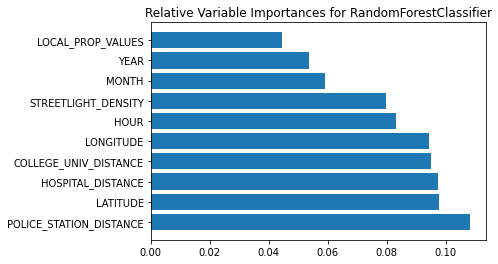

In [ ]:
plot_importances(rf_multi_pruned3, boston_X_train, 10)

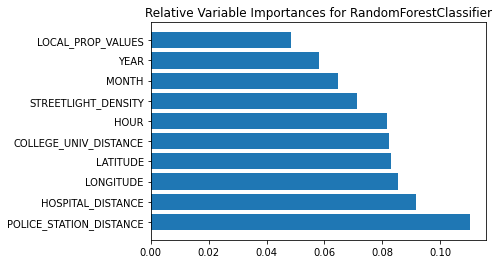

In [44]:
plot_importances(rf_multi_bal, boston_X_train, 10)

In [58]:
%%time
# Generalized multifactor with pruning
n_trees = 300
tree_depth = 20
min_samples = 10

rf_multi_full_pruned = RandomForestClassifier(max_depth=tree_depth, n_estimators=n_trees, max_features='sqrt', random_state=51, min_samples_leaf=min_samples)
rf_multi_full_pruned.fit(full_X_train, full_multi_y_train)

y_pred_rf_multi_full_pruned_train = rf_multi_full_pruned.predict(full_X_train)
y_pred_rf_multi_full_pruned_test = rf_multi_full_pruned.predict(full_X_test)

rf_multi_full_pruned_train = accuracy_score(full_multi_y_train, y_pred_rf_multi_full_pruned_train)
rf_multi_full_pruned_test = accuracy_score(full_multi_y_test, y_pred_rf_multi_full_pruned_test)

print(f"""Random Forest with {tree_depth} max_depth and {n_trees} trees and {min_samples} minimum samples per leaf, 
train accuracy is {rf_multi_full_pruned_train:.4f} and
test accuracy is {rf_multi_full_pruned_test:.4f}""")

Random Forest with 20 max_depth and 300 trees and 10 minimum samples per leaf, 
train accuracy is 0.4919 and
test accuracy is 0.4551
CPU times: user 11min 14s, sys: 5.07 s, total: 11min 19s
Wall time: 11min 20s


## AUC for Generalized Multi-factor

In [56]:
# binarizing multi_y train/test for to get AUC scores
labels = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
full_multi_y_train_bin = label_binarize(full_multi_y_train, classes=labels)
full_multi_y_test_bin = label_binarize(full_multi_y_test, classes=labels)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [60]:
y_pred_rf_multi_full_pruned_train_bin = label_binarize(y_pred_rf_multi_full_pruned_train, classes=labels)
y_pred_rf_multi_full_pruned_test_bin = label_binarize(y_pred_rf_multi_full_pruned_test, classes=labels)

auc_rf_multi_full_pruned_train = roc_auc_score(full_multi_y_train_bin, y_pred_rf_multi_full_pruned_train_bin, average='macro',multi_class='ovo')
auc_rf_multi_full_pruned_test = roc_auc_score(full_multi_y_test_bin, y_pred_rf_multi_full_pruned_test_bin, average='macro',multi_class='ovo')

print(f"""Random Forest AUCs(Generalized/Offense Type) 
Train: {auc_rf_multi_full_pruned_train:.4f}
Test: {auc_rf_multi_full_pruned_test:.4f}
""")

Random Forest AUCs(Generalized/Offense Type) 
Train: 0.5738
Test: 0.5639



## Generalized Multi-factor with balanced class weights

In [61]:
%%time
# Generalized multifactor with pruning
n_trees = 300
tree_depth = 20
min_samples = 10

rf_multi_full_bal = RandomForestClassifier(max_depth=tree_depth, n_estimators=n_trees, max_features='sqrt', class_weight="balanced_subsample", random_state=51, min_samples_leaf=min_samples)
rf_multi_full_bal.fit(full_X_train, full_multi_y_train)

y_pred_rf_multi_full_bal_train = rf_multi_full_bal.predict(full_X_train)
y_pred_rf_multi_full_bal_test = rf_multi_full_bal.predict(full_X_test)

rf_multi_full_bal_train = accuracy_score(full_multi_y_train, y_pred_rf_multi_full_bal_train)
rf_multi_full_bal_test = accuracy_score(full_multi_y_test, y_pred_rf_multi_full_bal_test)

print(f"""Random Forest (generalized/offense type/balanced) with {tree_depth} max_depth and {n_trees} trees and {min_samples} minimum samples per leaf, 
train accuracy is {rf_multi_full_bal_train:.4f} and
test accuracy is {rf_multi_full_bal_test:.4f}""")

Random Forest (generalized/offense type/balanced) with 20 max_depth and 300 trees and 10 minimum samples per leaf, 
train accuracy is 0.3033 and
test accuracy is 0.2133
CPU times: user 11min 18s, sys: 8.89 s, total: 11min 27s
Wall time: 11min 28s


# AUC for balanced Generalized/offense type

In [62]:
y_pred_rf_multi_full_bal_train_bin = label_binarize(y_pred_rf_multi_full_bal_train, classes=labels)
y_pred_rf_multi_full_bal_test_bin = label_binarize(y_pred_rf_multi_full_bal_test, classes=labels)

auc_rf_multi_full_bal_train = roc_auc_score(full_multi_y_train_bin, y_pred_rf_multi_full_bal_train_bin, average='macro',multi_class='ovo')
auc_rf_multi_full_bal_test = roc_auc_score(full_multi_y_test_bin, y_pred_rf_multi_full_bal_test_bin, average='macro',multi_class='ovo')

print(f"""Random Forest AUCs(Generalized/Offense Type) 
Train: {auc_rf_multi_full_bal_train:.4f}
Test: {auc_rf_multi_full_bal_test:.4f}
""")

Random Forest AUCs(Generalized/Offense Type) 
Train: 0.8529
Test: 0.6360



## AUC comparison for Generalized/Offense Type

In [63]:
print('Random Forest - Generalized. Predicting Offense Type')
pt = PrettyTable()
pt.field_names = ["Strategy","AUC Train", "AUC Test", "Train Acc", "Test Acc"]
pt.add_row(["RF - no correction",auc_rf_multi_full_pruned_train,auc_rf_multi_full_pruned_test, rf_multi_full_pruned_train, rf_multi_full_pruned_test])
pt.add_row(["RF - class weighting",auc_rf_multi_full_bal_train,auc_rf_multi_full_bal_test, rf_multi_full_bal_train, rf_multi_full_bal_test])
print(pt)

Random Forest - Generalized. Predicting Offense Type
+----------------------+-------------------+--------------------+---------------------+---------------------+
|       Strategy       |     AUC Train     |      AUC Test      |      Train Acc      |       Test Acc      |
+----------------------+-------------------+--------------------+---------------------+---------------------+
|  RF - no correction  | 0.573835182500568 | 0.5639271016588855 |  0.4918544530712808 | 0.45512242187304214 |
| RF - class weighting |  0.85293592548634 | 0.6360472556049279 | 0.30327027928708256 | 0.21331102924592135 |
+----------------------+-------------------+--------------------+---------------------+---------------------+


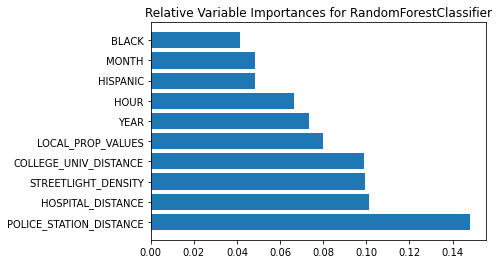

In [64]:
plot_importances(rf_multi_full_pruned, full_X_train, 10)

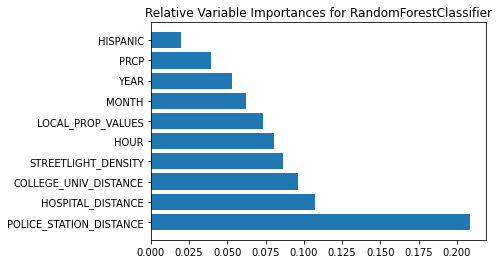

In [65]:
plot_importances(rf_multi_full_bal, full_X_train, 10)

In [ ]:
%%time
# Generalized multifactor with pruning
n_trees = 300
tree_depth = 20
min_samples = 20

rf_multi_full_pruned2 = RandomForestClassifier(max_depth=tree_depth, n_estimators=n_trees, max_features='sqrt', random_state=51, min_samples_leaf=min_samples)
rf_multi_full_pruned2.fit(full_X_train, full_multi_y_train)

y_pred_rf_multi_full_pruned_train2 = rf_multi_full_pruned2.predict(full_X_train)
y_pred_rf_multi_full_pruned_test2 = rf_multi_full_pruned2.predict(full_X_test)

rf_multi_full_pruned_train2 = accuracy_score(full_multi_y_train, y_pred_rf_multi_full_pruned_train2)
rf_multi_full_pruned_test2 = accuracy_score(full_multi_y_test, y_pred_rf_multi_full_pruned_test2)

print(f"""Random Forest with {tree_depth} max_depth and {n_trees} trees and {min_samples} minimum samples per leaf, 
train accuracy is {rf_multi_full_pruned_train2:.4f} and
test accuracy is {rf_multi_full_pruned_test2:.4f}""")

Random Forest with 20 max_depth and 300 trees and 20 minimum samples per leaf, 
train accuracy is 0.4738 and
test accuracy is 0.4520
CPU times: user 8min 55s, sys: 1.95 s, total: 8min 57s
Wall time: 8min 58s


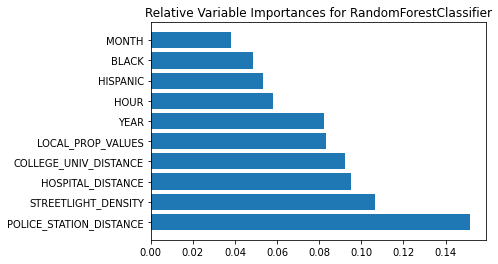

In [ ]:
plot_importances(rf_multi_full_pruned2, full_X_train, 10)

# K Nearest Neighbors
Yikes, this was time-instensive to run.

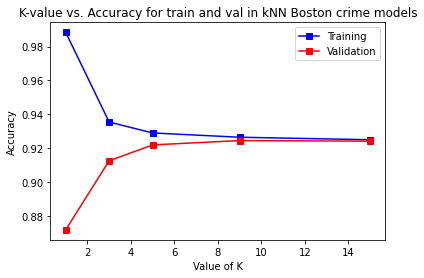

Best value of K is 9
Train accuracy of best (k=9) model: 0.9272
Test accuracy of best (k=9) model: 0.9252


In [ ]:
training_error, validation_error = [],[]

ks = [1,3,5,9,15]

for k in ks:
    
    knn = KNeighborsClassifier(n_neighbors=k)

    knn_cv = cross_validate(knn,boston_X_train_scaled,boston_y_train, scoring="accuracy", return_train_score=True, cv=3)
    
    acc_train = knn_cv['train_score'].mean()
    acc_val = knn_cv['test_score'].mean()
        
    training_error.append(acc_train)
    validation_error.append(acc_val)
    
plt.plot(ks, training_error, 's-', color="blue", label="Training")
plt.plot(ks, validation_error, 's-', color="red", label="Validation")
plt.xlabel("Value of K")
plt.ylabel("Accuracy")
plt.title("K-value vs. Accuracy for train and val in kNN Boston crime models")
plt.legend()
plt.show()

best_acc  = max(validation_error)
best_k = ks[validation_error.index(best_acc)]

print(f'Best value of K is {best_k}')

knn_model = KNeighborsClassifier(n_neighbors=best_k).fit(boston_X_train_scaled,boston_y_train)

knn_model_train_accuracy = knn_model.score(boston_X_train_scaled, boston_y_train)
knn_model_test_accuracy = knn_model.score(boston_X_test_scaled, boston_y_test)

print(f'Train accuracy of best (k={best_k}) model: {knn_model_train_accuracy:.4f}')
print(f'Test accuracy of best (k={best_k}) model: {knn_model_test_accuracy:.4f}')

In [ ]:
# knn with same best K, coding so don't have to redo analysis
best_k = 9

# knn on full data for violent/non-violent
knn_model_full = KNeighborsClassifier(n_neighbors=best_k).fit(full_X_train_scaled, full_y_train)

knn_model_full_train_accuracy = knn_model_full.score(full_X_train_scaled, full_y_train)
knn_model_full_test_accuracy = knn_model_full.score(full_X_test_scaled, full_y_test)

print(f'Train accuracy of best (k={best_k}) model: {knn_model_full_train_accuracy:.4f}')
print(f'Test accuracy of best (k={best_k}) model: {knn_model_full_test_accuracy:.4f}')

Train accuracy of best (k=9) model: 0.8894
Test accuracy of best (k=9) model: 0.8828


kNN with the same best k from Boston only did not do any better than naive model on the full dataset. Since even this one run took quite a long time, and kNN is not very interpretable, it makes sense that this is not a good model to pursue